In [2]:
pip install faker pandas mysql-connector-python streamlit matplotlib seaborn pandas sqlalchemy pymysql

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import random
from faker import Faker

fake = Faker()

categories = ["Food", "Transport", "Entertainment", "Shopping", "Healthcare", "Bills", "Education", "Miscellaneous"]
payment_methods = ["Credit Card", "Debit Card", "Cash", "UPI", "Net Banking"]

def generate_expenses(num_entries=100):
    data = []
    for _ in range(num_entries):
        name = fake.name()
        category = random.choice(categories)
        amount = round(random.uniform(50, 5000), 2)
        date = fake.date_between(start_date="-1y", end_date="today")
        payment_method = random.choice(payment_methods)
        description = fake.sentence(nb_words=6)
        data.append([name, category, amount, date, payment_method, description])
    
    return pd.DataFrame(data, columns=["name", "category", "amount", "date", "payment_method", "description"])

for month in range(1, 13):
    df = generate_expenses(200) 
    df.to_csv(f'expenses_{month}.csv', index=False)

print("Data for 12 months generated and saved as CSV files.")


Data for 12 months generated and saved as CSV files.


In [1]:
import mysql.connector

In [25]:
mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  password="Abhi@280695",
  database="expense.db"
)

In [28]:
pip install mysql-connector-python

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



In [8]:
import mysql.connector 
conn = mysql.connector.connect(
    host="localhost",
    user="root",
    password="Abhi@280695"
)
if conn.is_connected():
    print("Successfully connected to MySQL")

    cursor = conn.cursor()

    cursor.execute("CREATE DATABASE IF NOT EXISTS ExpenseDB")
    cursor.execute("USE ExpenseDB")

    for month in range(1, 13):
        table_name = f"Month_{month}"
        cursor.execute(f"""
            CREATE TABLE IF NOT EXISTS {table_name} (
                id INT AUTO_INCREMENT PRIMARY KEY,
                name VARCHAR(255),
                category VARCHAR(100),
                amount DECIMAL(10,2),
                date DATE,
                payment_method VARCHAR(50),
                description TEXT
            )
        """)

    conn.commit()
    print("Database and tables created successfully.")

Successfully connected to MySQL
Database and tables created successfully.


In [9]:
import pandas as pd
import mysql.connector

conn = mysql.connector.connect(
    host="localhost",
    user="root",
    password="Abhi@280695",
    database="ExpenseDB"
)
cursor = conn.cursor()

for month in range(1, 13):
    table_name = f"Month_{month}"
    df = pd.read_csv(f"expenses_{month}.csv")

    for _, row in df.iterrows():
        cursor.execute(f"""
            INSERT INTO {table_name} (name, category, amount, date, payment_method, description)
            VALUES (%s, %s, %s, %s, %s, %s)
        """, tuple(row))

conn.commit()
cursor.close()
conn.close()
print("Data inserted into MySQL tables.")


Data inserted into MySQL tables.


C:\Users\USER\AppData\Local\Temp\ipykernel_12084\4209623683.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


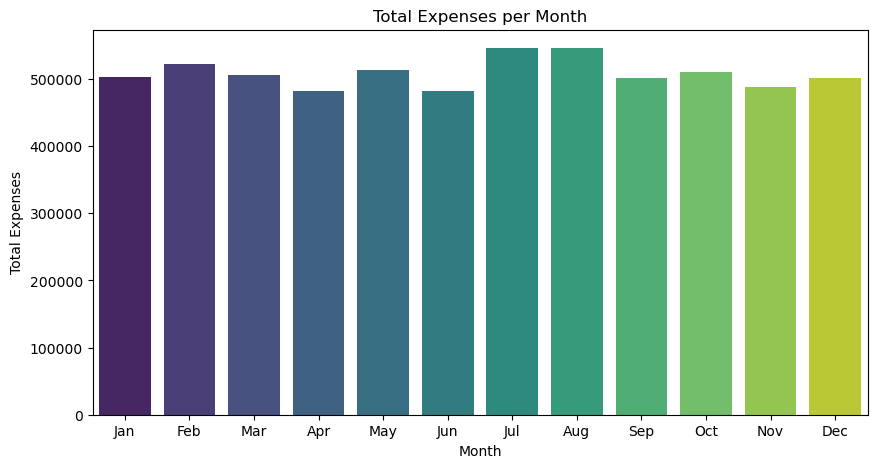

In [1]:
import pandas as pd
import mysql.connector
import seaborn as sns
import matplotlib.pyplot as plt

conn = mysql.connector.connect(
    host="localhost",
    user="root",
    password="Abhi@280695",
    database="ExpenseDB"
)

months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

query = " UNION ALL ".join(
    [f"SELECT '{months[i-1]}' AS month, SUM(amount) AS total_spent FROM Month_{i}" for i in range(1, 13)]
)

df = pd.read_sql_query(query, conn)
conn.close()

df['month'] = pd.Categorical(df['month'], categories=months, ordered=True)
df = df.sort_values('month')

plt.figure(figsize=(10, 5))
sns.barplot(x=df['month'], y=df['total_spent'], hue=df['month'], palette="viridis", legend=False)
plt.xlabel("Month")
plt.ylabel("Total Expenses")
plt.title("Total Expenses per Month")
plt.show()

In [2]:
pip install streamlit

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


2025-03-15 10:12:19.609 
  command:

    streamlit run C:\ProgramData\anaconda3\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
C:\Users\USER\AppData\Local\Temp\ipykernel_12084\1771007888.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)
2025-03-15 10:12:20.436 Session state does not function when running a script without `streamlit run`


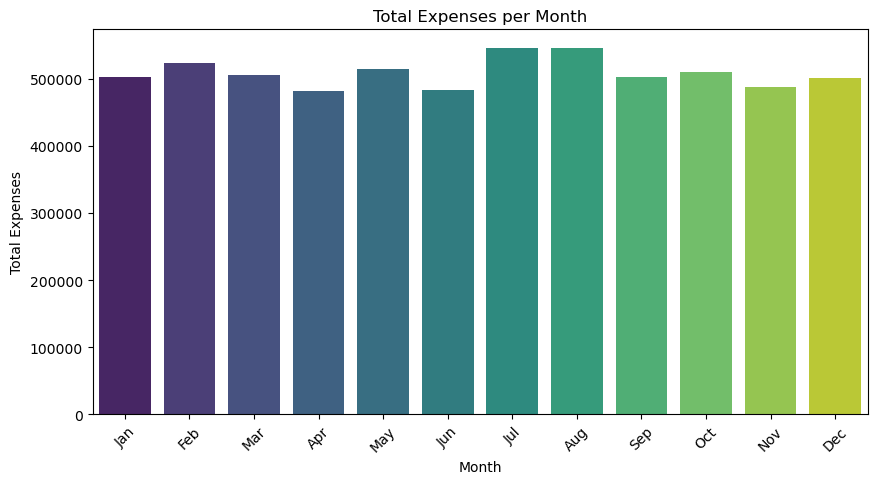

In [2]:
import streamlit as st
import pandas as pd
import mysql.connector
import seaborn as sns
import matplotlib.pyplot as plt

# Function to Connect and Fetch Data from MySQL
def get_data(query):
    conn = mysql.connector.connect(
        host="localhost",
        user="root",
        password="Abhi@280695",
        database="ExpenseDB"
    )
    df = pd.read_sql_query(query, conn)
    conn.close()
    return df

st.title("Personal Expense Dashboard")

st.subheader("Total Expenses per Month")

months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

query = " UNION ALL ".join(
    [f"SELECT '{months[i-1]}' AS month, COALESCE(SUM(amount), 0) AS total_spent FROM Month_{i}" for i in range(1, 13)]
)

df = get_data(query)

df['month'] = pd.Categorical(df['month'], categories=months, ordered=True)
df = df.sort_values('month')

st.dataframe(df)

if df.empty:
    st.warning("No expense data found!")
else:
    df['total_spent'] = df['total_spent'].astype(float)  # Ensure correct type

    fig, ax = plt.subplots(figsize=(10, 5))
    sns.barplot(x=df['month'], y=df['total_spent'], hue=df['month'], palette="viridis", legend=False)
    plt.xlabel("Month")
    plt.ylabel("Total Expenses")
    plt.title("Total Expenses per Month")
    plt.xticks(rotation=45)
    st.pyplot(fig)

st.subheader("Run SQL Query")
query = st.text_area("Enter SQL Query:")
if st.button("Execute"):
    if query:
        result_df = get_data(query)
        st.dataframe(result_df)

st.sidebar.write("Developed by [Abhishek Kumar Singh]")

In [5]:
import os
os.environ["PYDEVD_DISABLE_FILE_VALIDATION"] = "1"